# Activation Tuning

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import kerastuner as kt # for tuning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras import regularizers

In [63]:
df = pd.read_csv('diabetes.csv')
X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 0.6839137 , -0.70579433, -0.625833  , ...,  0.26501306,
        -0.11390738,  0.87654579],
       [-0.52726014, -0.26972894,  0.29889263, ...,  0.48823955,
        -0.94569142, -1.03690611],
       [-0.52726014, -0.39431905, -0.29945925, ..., -0.15517797,
        -0.91619553, -1.03690611],
       ...,
       [ 0.6839137 ,  0.07289387,  0.13570575, ...,  0.21248918,
         0.77981801,  0.09377001],
       [-0.22446668, -1.32874488, -1.06099801, ..., -0.12891603,
        -0.65073254, -0.60203068],
       [-0.22446668, -0.45661411,  0.13570575, ..., -0.81172646,
        -0.77166568, -0.51505559]])

In [64]:
def build_model_activation(hp):
    model = Sequential()

    for i in range(hp.Int('num_layers',1,3)):
        if i == 0:
            model.add(Dense(
                units = 32,
                activation = hp.Choice(name = 'activation',values = ['relu','tanh','elu']),
                input_dim =8))
        else:
            model.add(Dense(
                units = 128,
                activation = hp.Choice(name = 'activation',values = ['relu','tanh','elu']),
                kernel_regularizer = regularizers.L2(0.02)
            ))
    model.add(Dense(
        units = 1,
        activation = 'sigmoid'
    ))


    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adadelta'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [65]:
# def build_model_activation(hp):
#     model = Sequential()
#     input_dim = 8

#     for i in range(hp.Int('num_layers', 1, 3)):  # Define the number of layers
#         if i == 0:
#             model.add(Dense(units=32,
#                             activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'elu']),
#                             input_dim=input_dim))
#         else:
#             model.add(Dense(units=128,
#                             activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'elu']),
#                             kernel_regularizer=regularizers.L2(0.01)))

#     model.add(Dense(units=1, activation='sigmoid'))

#     optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adadelta'])
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#     return model


In [66]:
tuner = kt.RandomSearch(
    hypermodel=build_model_activation,
    objective='val_accuracy',
    max_trials=5,
    directory ='tuner',
    project_name = 'ActivationTuner'
)

In [67]:
tuner.search(X_train,y_train,epochs = 5,validation_data = (X_test,y_test))

Trial 5 Complete [00h 00m 01s]
val_accuracy: 0.7239583134651184

Best val_accuracy So Far: 0.7447916865348816
Total elapsed time: 00h 00m 08s
INFO:tensorflow:Oracle triggered exit


In [68]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3, 'activation': 'elu', 'optimizer': 'rmsprop'}

In [69]:
model = tuner.get_best_models(num_models=1)[0]
model

In [70]:
history = model.fit(X_train,y_train,batch_size=32,epochs=100,initial_epoch=5,validation_data=(X_test,y_test))

Epoch 6/100
18/18 [==============================] - 1s 14ms/step - loss: 4.2254 - accuracy: 0.6319 - val_loss: 4.6164 - val_accuracy: 0.5938
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 3.6708 - accuracy: 0.6528 - val_loss: 3.1960 - val_accuracy: 0.6875
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 3.6545 - accuracy: 0.6337 - val_loss: 3.3520 - val_accuracy: 0.6667
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 3.1166 - accuracy: 0.6493 - val_loss: 2.8423 - val_accuracy: 0.7031
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 2.9549 - accuracy: 0.6354 - val_loss: 2.8919 - val_accuracy: 0.6562
Epoch 11/100
18/18 [==============================] - 0s 3ms/step - loss: 2.5437 - accuracy: 0.7326 - val_loss: 3.3357 - val_accuracy: 0.6302
Epoch 12/100
18/18 [==============================] - 0s 3ms/step - loss: 2.4733 - accuracy: 0.6701 - val_loss: 2.2725 - val_accuracy: 0.7552
Epoch 13/

In [71]:
100-6

94

Text(0.5, 1.0, 'val_loss- 0.62 and loss- 0.521')

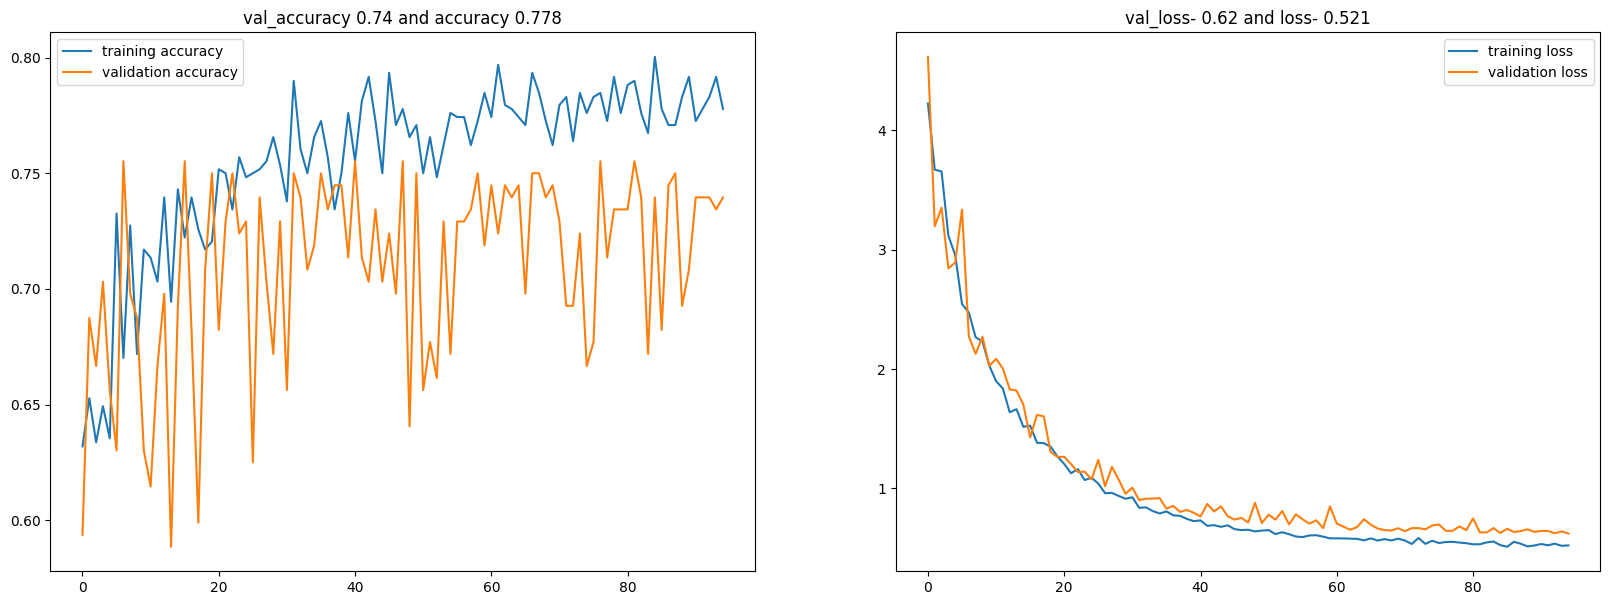

In [72]:
plt.subplots(nrows=1,ncols=2,figsize = (20,7))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training accuracy','validation accuracy'])
plt.title(f'val_accuracy {round(history.history["val_accuracy"][94],ndigits=3)} and accuracy {round(history.history["accuracy"][94],ndigits=3)}')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title(f'val_loss- {round(history.history["val_loss"][94],ndigits=3)} and loss- {round(history.history["loss"][94],ndigits=3)}')
